### 편미분방정식 수치해석 기법
- 유체나 탄성체 또는 변형체의 운동 법칙을 표현하거나 또는 여러가지 공학적인 문제를 모델링하고 해석하는데 편미분 방정식(PDE, partial differential equation)이 사용
- 전통적인 수치 방법은 유한차분법(FDM), 유한요소법(FEM) 등이 있음
- 메쉬 기반으로서 계산 영역을 수많은 작은 메쉬로 분할하고 각 메쉬 포인트에서 수치해를 얻는 것
- 계산량이 매우 많으며 복잡한 형상에서는 적용하기 어려움

### PINN
- Raissi가 개발한 물리 정보 신경망
- 편미분 방정식을 충족하도록 강제하는 방식으로 편미분 방정식에 내재되어 있는 물리 정보를 신경망에 도입
- 신경망 학습에 필요한 데이터를 줄일 수 있고, 학습 속도를 빠르게 할 수 있는 것
- 물리학과 데이터를 모두 사용하여 손실 함수를 계산할 수 있음

기존 신경망의 단점을 보완
- data + physics to build a model
- 기존 신경망의 단점 보완
- 축적된 과학 이론의 사전 지식으로 데이터 과학 방법을 최대한 활용 -> 예측 성능 향상
- 데이터 불균형 및 데이터 부족 문제를 해결하기 위한 도메인 지식 통합

In [1]:
import math
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim

import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets as datasets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
data = pd.read_excel('/content/drive/MyDrive/2025_1_Colab/DeepLearning/Lib/PINN/PINN_ex1.xlsx')
data

,time,Height(m)
0,0.0,1000.000
1,0.2,999.804
2,0.4,999.216
3,0.6,998.236
4,0.8,996.864
...,...,...
66,13.2,146.224
67,13.4,120.156
68,13.6,93.696
69,13.8,66.844


In [4]:
train_time = 40
x_train = torch.Tensor(data.loc[:train_time,'time'].values).reshape(-1,1).to(device)
y_train = torch.Tensor(data.loc[:train_time, 'Height(m)'].values).reshape(-1, 1).to(device)

x_test = torch.Tensor(data.loc[train_time+1:, 'time'].values).reshape(-1, 1).to(device)
y_test = torch.Tensor(data.loc[train_time+1:, 'Height(m)'].values).reshape(-1, 1).to(device)

In [5]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()

    self.l1 = nn.Linear(1, 50)
    self.l2 = nn.Linear(50, 50)
    self.l3 = nn.Linear(50, 50)
    self.l4 = nn.Linear(50, 1)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.l1(x)
    x = self.relu(x)
    x = self.l2(x)
    x = self.relu(x)
    x = self.l3(x)
    x = self.relu(x)
    x = self.l4(x)
    return x

In [6]:
torch.cuda.manual_seed(123)
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

In [7]:
loss_train_record = []
loss_test_record = []
for epoch in range(10000):
  optimizer.zero_grad()

  preds_train = model(x_train)
  preds_test = model(x_test)

  loss_train = nn.MSELoss()(preds_train, y_train)
  loss_test = nn.MSELoss()(preds_test, y_test)

  loss_train.backward()
  optimizer.step()

  loss_train_record.append(loss_train.item())
  loss_test_record.append(loss_test.item())
  if epoch % 1000 == 0:
    print(f'epoch: {epoch}, loss_train: {loss_train.item()}, loss_test: {loss_test.item()}')

epoch: 0, loss_train: 808414.5625, loss_test: 181047.28125
epoch: 1000, loss_train: 222.31527709960938, loss_test: 330148.96875
epoch: 2000, loss_train: 24.81772804260254, loss_test: 225645.09375
epoch: 3000, loss_train: 23.652084350585938, loss_test: 224140.578125
epoch: 4000, loss_train: 21.988943099975586, loss_test: 223108.4375
epoch: 5000, loss_train: 19.59994125366211, loss_test: 224329.5
epoch: 6000, loss_train: 15.629751205444336, loss_test: 232194.90625
epoch: 7000, loss_train: 10.349957466125488, loss_test: 240635.34375
epoch: 8000, loss_train: 6.506676197052002, loss_test: 240343.03125
epoch: 9000, loss_train: 3.7899250984191895, loss_test: 233028.265625


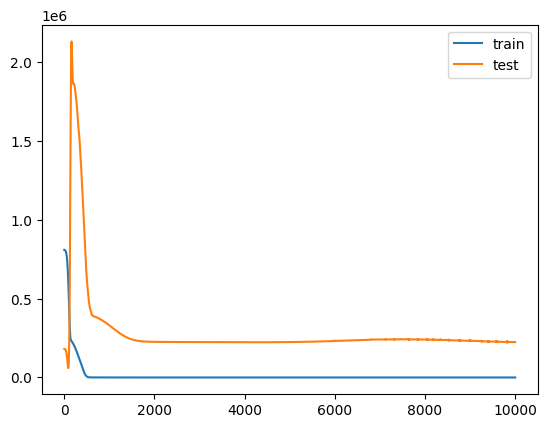

In [8]:
plt.plot(loss_train_record, label = 'train')
plt.plot(loss_test_record, label = 'test')
plt.legend()
plt.show()

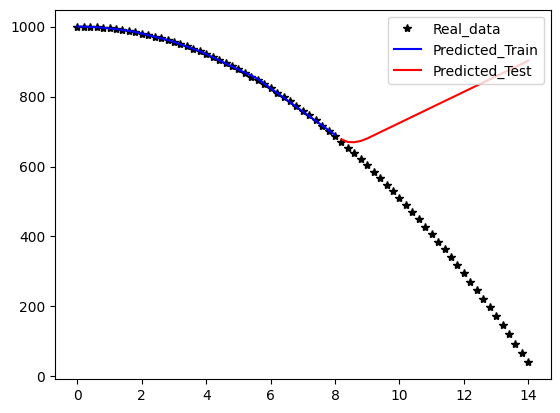

In [9]:
with torch.no_grad():
  plt.plot(data['time'], data['Height(m)'], '*', color = 'black', label = 'Real_data')
  plt.plot(x_train.cpu(), preds_train.cpu(), color = 'blue', label = 'Predicted_Train')
  plt.plot(x_test.cpu(), preds_test.cpu(), color = 'red', label = 'Predicted_Test')
  plt.legend(loc = 'upper right')
  plt.show()

In [10]:
# PINN
def ODE(t):
  return -9.8 * t

# Set Boundary conditions and inital point:
x_H0 = torch.Tensor([0])
y_H0 = torch.Tensor([1000])

### Deep collocation method (심층 코로케이션 방법)
#### Monte Carlo sampling method
- 반복된 부작위 추출을 이용하여 함수의 값을 수리적으로 근사하는 알고리즘을 부르는 용어

1. 가지고 있는 데이터에 상관없이 정의역(시간)에 범위 또는 구하고자 하는 시간의 범위를 정한다
2. 반복된 무작위 추출 함수로 uniform random distribution 함수를 이용하여 정해진 범위에 N개의 무작위 샘플링을 한다
3. 무작위 샘플링한 시간의 미분방정식 값과 신경망에서 구한 미분값과의 평균제곱오차를 계산한다.

In [11]:
# Set the number collocation points

time_start = data.loc[0,'time']
time_end = data.loc[len(data)-1, 'time']

N_colloc = 1000

# Colllocation point
X_colloc = torch.rand(N_colloc, 1) * (time_end - time_start) + time_start

In [13]:
# Store tensors to GPU
X_colloc = X_colloc.to(device)
x_H0 = x_H0.to(device)
y_H0 = y_H0.to(device)

In [12]:
class PINN_test(nn.Module):
  def __init__(self):
    super().__init__()

    self.tanh = nn.Tanh()

    self.l1 = nn.Linear(1, 50)
    self.l2 = nn.Linear(50, 50)
    self.l3 = nn.Linear(50, 50)
    self.l4 = nn.Linear(50, 1)

  def forward(self, x):
    x = self.l1(x)
    x = self.tanh(x)
    x = self.l2(x)
    x = self.tanh(x)
    x = self.l3(x)
    x = self.tanh(x)
    x = self.l4(x)
    return x

In [14]:
torch.cuda.manual_seed(123)
model_P = PINN_test().to(device)
optimizer_P = torch.optim.Adam(model_P.parameters(), lr = 0.005)

In [16]:
loss_train_P = []
loss_test_P = []
for epoch in range(30000):
  # 초기값에 대한 손실함수
  loss_BC = nn.MSELoss()(model_P(x_H0), y_H0)

  # 미분방정식에 대한 손실함수
  X_colloc.requires_grad = True
  f = model_P.forward(X_colloc)
  f_x = torch.autograd.grad(f, X_colloc, torch.ones([X_colloc.shape[0],1]).to(device),retain_graph=True ,create_graph = True)[0]
  loss_ODE = nn.MSELoss()(f_x, ODE(X_colloc))

  # 데이터에 대한 손실함수
  loss_Data = nn.MSELoss()(model_P.forward(x_train), y_train)

  loss = loss_BC + loss_ODE + loss_Data

  loss_test = nn.MSELoss()(model_P.forward(x_test), y_test)
  optimizer_P.zero_grad()
  loss.backward()
  optimizer_P.step()

  loss_train_P.append(loss.item())
  loss_test_P.append(loss_test.item())

  if epoch % 1000 == 0:
    print(f'epoch: {epoch}, loss: {loss.item()}, loss_valid: {loss_test.item()}')

epoch: 0, loss: 1814417.75, loss_valid: 181115.5
epoch: 1000, loss: 1007557.375, loss_valid: 54365.890625
epoch: 2000, loss: 506825.1875, loss_valid: 40901.328125
epoch: 3000, loss: 217274.25, loss_valid: 99217.78125
epoch: 4000, loss: 77560.921875, loss_valid: 193407.703125
epoch: 5000, loss: 29887.0390625, loss_valid: 284178.625
epoch: 6000, loss: 21401.015625, loss_valid: 338167.6875
epoch: 7000, loss: 16009.716796875, loss_valid: 319548.15625
epoch: 8000, loss: 11692.0810546875, loss_valid: 285521.0
epoch: 9000, loss: 10705.384765625, loss_valid: 276281.53125
epoch: 10000, loss: 9725.65625, loss_valid: 264645.5625
epoch: 11000, loss: 8828.8125, loss_valid: 252489.734375
epoch: 12000, loss: 8035.6826171875, loss_valid: 239875.3125
epoch: 13000, loss: 7346.6279296875, loss_valid: 227567.75
epoch: 14000, loss: 6791.68408203125, loss_valid: 216034.625
epoch: 15000, loss: 6292.1767578125, loss_valid: 203800.109375
epoch: 16000, loss: 5917.1123046875, loss_valid: 192922.34375
epoch: 1700

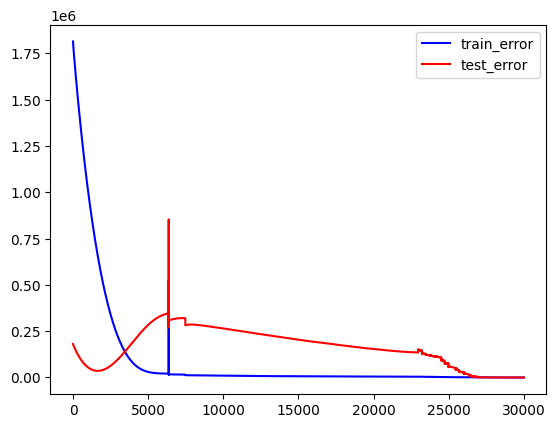

In [19]:
plt.plot(loss_train_P, 'b',label = 'train_error')
plt.plot(loss_test_P, 'r',label = 'test_error')
plt.legend()
plt.show()

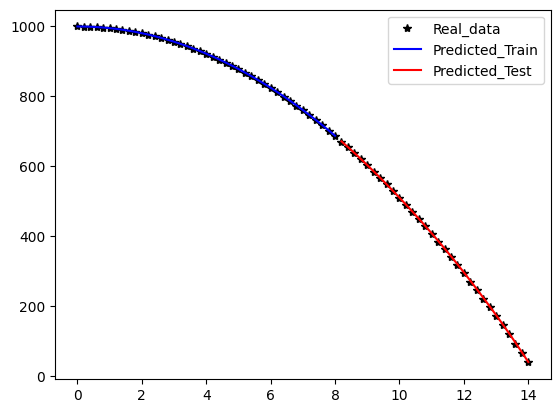

In [18]:
with torch.no_grad():
  plt.plot(data['time'], data['Height(m)'], '*', color = 'black', label = 'Real_data')
  plt.plot(x_train.cpu(), model_P(x_train).cpu(), color = 'blue', label = 'Predicted_Train')
  plt.plot(x_test.cpu(), model_P(x_test).cpu(), color = 'red', label = 'Predicted_Test')
  plt.legend(loc = 'upper right')